# Ouverture du fichier audio et affichage de la forme d'onde

In [7]:
import numpy as np
import pandas as pd
import scipy.io.wavfile
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
filename = "dataset/conversation.wav" 
data = scipy.io.wavfile.read(filename)
print( data)
# on voit que la frequence d'echantillaunage est 44100, 
# array represent le nombre d'echantillons

(44100, array([ -43,  -54,  -57, ..., -191, -117,  -20], dtype=int16))


In [9]:
sampling_rate = data[0]

duration = len(data[1])/float(sampling_rate)  #la durée en seconds de notre audio = nombre d'echantillons / par frequence d'echantillaunage 
t = np.arange(0, duration, 1/float(sampling_rate)) #le temps de chaque echantillon = on utilise une arrange pour créer un tableau qui part du 0
t

array([0.00000000e+00, 2.26757370e-05, 4.53514739e-05, ...,
       7.47993197e+00, 7.47995465e+00, 7.47997732e+00])

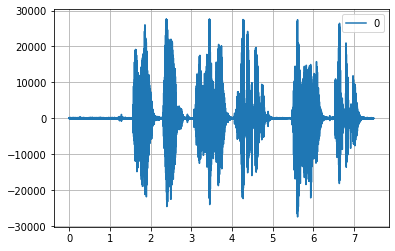

In [10]:
df = pd.DataFrame(data[1], index=t) #dataframe pandas

df.plot(grid=True)
plt.show() 
# resultat : enveloppe des données qui contiant le son des voix un homme et d'une femme

# Affichage du spectrogramme

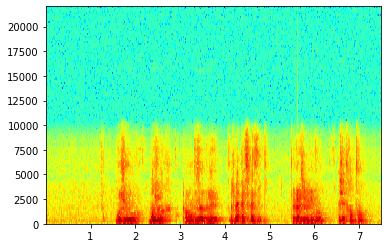

In [11]:
#affichage de spectre du son avec de bruits
#grace au frequance on peut voir l'apparance et la force du son sur l'arrier plan
sp, f, t, im=plt.specgram( data[1], Fs=sampling_rate, cmap='jet'); #sp - spectre

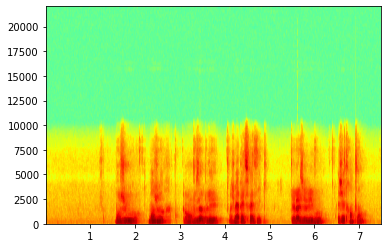

In [12]:
#on met le temps t dans index (lignes), frequance f sur columns (colonnes), pour decouper plus facilement

sp_df = pd.DataFrame(10*np.log10(sp.T), index=t, columns=f)

plt.contourf( sp_df.index, sp_df.columns, sp_df.T, 256, cmap=plt.jet(), vmin=-150, vmax=60)

#sp_df #affichage

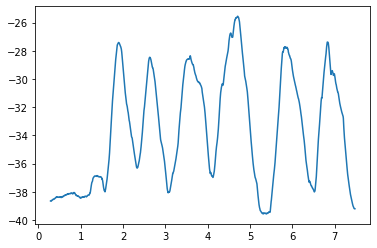

In [13]:
#si on regarde colonne par colonne (c'est à dire instint par instint), pixel par pixel
#imaginons faire la moyenne (colonne par colonne) - c'est represant la puissanse
#chaque pixel(ligne) a la puissance à chaque instint de chaque composant d'une frequance
#faire une moyenne (instint par instint : axis=1)
#pour lisser (nettoyer, supprimer) le bruiage on utilise la filtre : rolling(100).mean()

sp_df_mean = sp_df.mean(axis=1).rolling(100).mean()  #où on peut faire median() à la place de mean(), mais ecrase plus de donnée
sp_df_mean.plot()

#resultat : partie en bas - silence, en haut - il y a du son (en coherance de puissance du son)
#à partir d'ici on peut imaginer un seuil pour destinger les sons et les silences (arrier plan et premier plan)

In [14]:
#pour faire le seuil on regarde la moyenne qui vaut (-33,6) et le standard deviation qui vaut (4)

sp_df_mean.mean(), sp_df_mean.std()

(-33.60485948379491, 4.009855357001593)

# Definition du seuil

-36.01077269799587

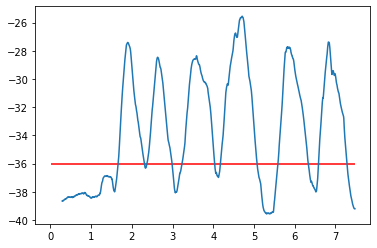

In [15]:
ax = sp_df_mean.plot()

#faisons un seuil en utilisant la moyenne et standart deviation (ceux qui sont plus haut de ce seuil ont du son, ceux qui sont plus bas de ce seuil ont du silance)
#on utilise standard deviation comme le seuil de la voix
son_th = sp_df_mean.mean() -0.6*sp_df_mean.std() #ici on a essayé le coefficient egale à -0.6 pour etablir le seuil au niveau 36
#affichage comme horizontal line = (y, à partir de premier instint temporelle, jusqu'à dernier instint, r - coleur rouge)
ax.hlines( son_th, sp_df_mean.index[0], sp_df_mean.index[-1], 'r')
son_th

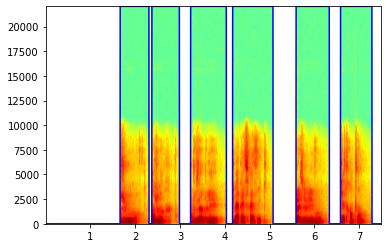

In [16]:
#le son est la où la moyenne est majeur du seuil qui nous avons viens de definir en fonction de la moyenne (la moyenne globale)
son_idx = (sp_df_mean>son_th)

#on fait l'isolation des partie avec du son
son_sp_df = sp_df.copy(True)
#on force toute la partie qui n'est pas voix (la silence) etre disparu
son_sp_df[son_idx==False] = np.nan   #np.nan suprime les données de bruit (on peut mettre 0 aussi, mais 0 c'est une valeur quand même c'est pourquoi il va mieux de juste supprimer les données de l'arrier plan)

ax = plt.subplot(111)
#imprime le spectre
ax.contourf( son_sp_df.index, son_sp_df.columns, son_sp_df.T, 256, cmap=plt.jet(), vmin=-150, vmax=60)
#imprime lignes bleus (qui sont 0 - pas de voix, 1 - il y a un voix)
(son_idx*son_sp_df.columns[-1]).plot( ax=ax, c='b')
#resultat: on a decouper les 6 sons, derier - le background (suprimé)

# Differencier des sons differents (en utilisant la transformation de Fourrier)

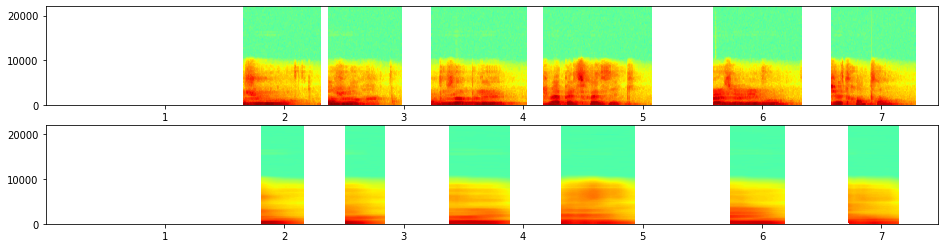

In [17]:
#faisons une moyenne glissante (les petites fenetres qui glissent, et pour chaque fenetre calcule sa moyenne pour chaque ligne)
#on cherche ces qui restent constante pendant les sons

plt.figure(figsize=(16,4))
plt.subplot(211)
plt.contourf( son_sp_df.index, son_sp_df.columns, son_sp_df.T, 256, cmap=plt.jet(), vmin=-150, vmax=60)
plt.subplot(212)
plt.contourf( son_sp_df.index, son_sp_df.columns, son_sp_df.rolling(100,center=True).mean().T, 256, cmap=plt.jet(), vmin=-150, vmax=60)
#son_sp_df.rolling(100,center=True).mean().T - fait la moyenne pour chaque ligne sur des fenetres glissantes de la taille 100
#resultat : supprimé toutes les petites variations, fait un bleuring

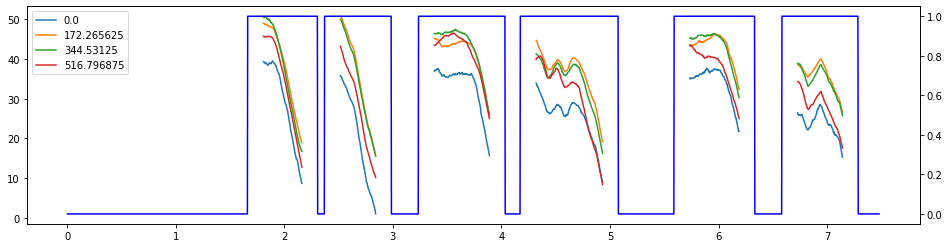

In [18]:
id_sp = son_sp_df.rolling(100,center=True).mean()

plt.figure(figsize=(16,4))
ax = plt.subplot(111)

#prennons les premiers 4 ligne (à partir de 0 à 4) et voyons l'evaluation temporelle comme un plot
ax = id_sp[id_sp.columns[0:4]].plot(ax=ax,legend=False)
plt.legend(loc='upper left')
(son_idx*1).plot( ax=ax, c='b', secondary_y=True)

#on analyse ligne par ligne pour deffinir quelle ligne on va utiliser comme le diviseur

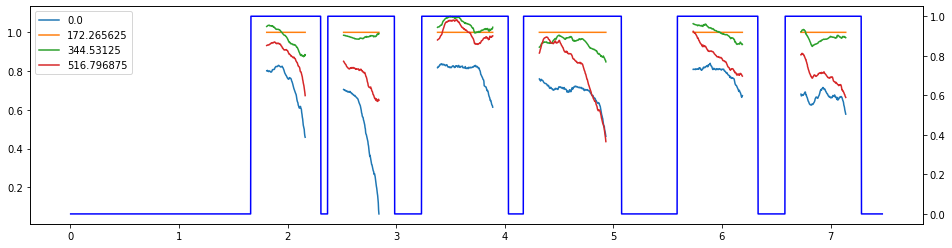

In [19]:
#on divise toutes les ligne par la ligne orange (qui on utilise comme une referance) (id_sp[id_sp.columns[1]])
plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax = id_sp[id_sp.columns[0:4]].divide( id_sp[id_sp.columns[1]], axis=0).plot(ax=ax,legend=False) #créé 4 lignes
plt.legend(loc='upper left')
(son_idx*1).plot( ax=ax, c='b', secondary_y=True)

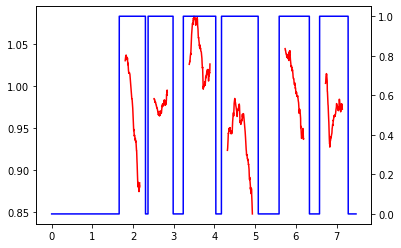

In [20]:
#affichage seulement la ligne vert

plt.figure()
ax = plt.subplot(111)
(son_idx*1).plot( ax=ax, c='b', secondary_y=True)
(id_sp[id_sp.columns[2]]/id_sp[id_sp.columns[1]]).plot(ax=ax, c='r')

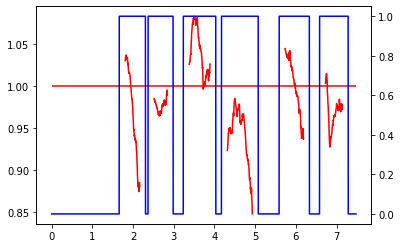

In [21]:
id_th = 1 #seuil

plt.figure()
ax = plt.subplot(111)
(son_idx*1).plot( ax=ax, c='b', secondary_y=True)
(id_sp[id_sp.columns[2]]/id_sp[id_sp.columns[1]]).plot(ax=ax, c='r')
ax.hlines( id_th, id_sp.index[0], id_sp.index[-1], 'r')

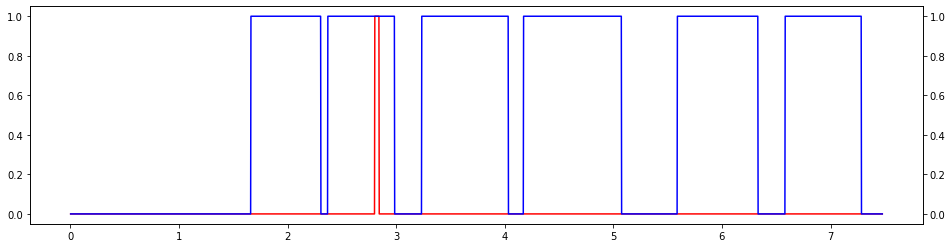

In [22]:
#tous ces qui est inferieur de ce seuil c'est le premier objet, tous ces qui est superieur de ce seuil c'est le deuxieme objet

id_idx = (id_sp[id_sp.columns[3]]/id_sp[id_sp.columns[4]]) < id_th  #deffinition si il s'agit 2 types de son

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
(id_idx*1).plot(ax=ax, c='r')
(son_idx*1).plot( ax=ax, c='b', secondary_y=True)
#resultat : extraire la voix de femme (quand elle parle premiere fois)
#tous les autres sons il considere comme les sons d'autres objets

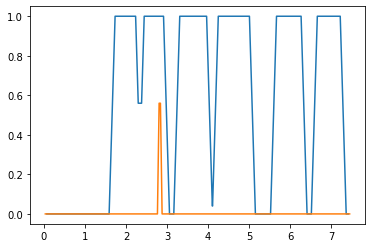

In [23]:
w = 50
(son_idx*1).rolling(int(w),center=True).mean().plot()
(id_idx*1).rolling(int(w/2),center=True).mean().plot()

#en orange on a la probabilité d'appartenir au son 0 au au son 0.55 en accord de la taille de la fenetre
#on peut dire qu'il y du son sur la partie où on a orange au niveau 0.55, et on n'a pas du son sur la partie où on a orange au niveau 0 (mais ça peut etre une erreur£)

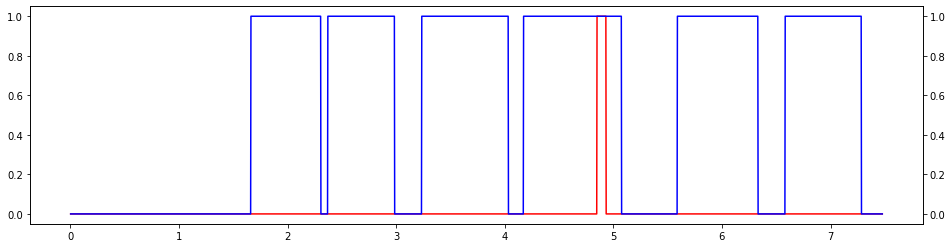

In [24]:
id_idx = (id_sp[id_sp.columns[3]]/id_sp[id_sp.columns[7]]) < id_th

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
(id_idx*1).plot(ax=ax, c='r')
(son_idx*1).plot( ax=ax, c='b', secondary_y=True)

#resultat : extraire la voix de femme (quand elle parle deuxieme fois)

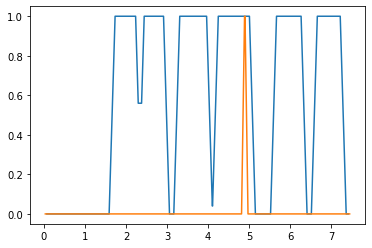

In [25]:
w = 50
(son_idx*1).rolling(int(w),center=True).mean().plot()
(id_idx*1).rolling(int(w/2),center=True).mean().plot()

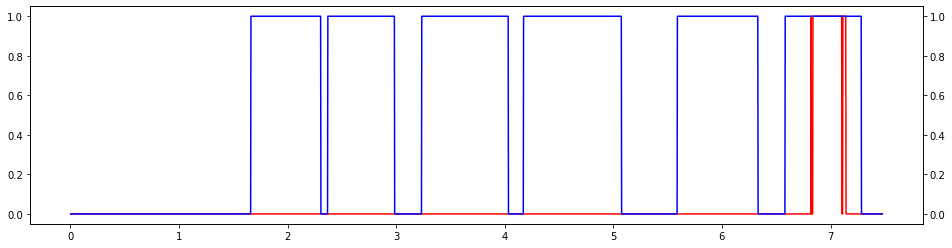

In [26]:
id_idx = (id_sp[id_sp.columns[4]]/id_sp[id_sp.columns[5]]) < id_th

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
(id_idx*1).plot(ax=ax, c='r')
(son_idx*1).plot( ax=ax, c='b', secondary_y=True)

#resultat : extraire la voix de femme (quand elle parle troisieme fois)

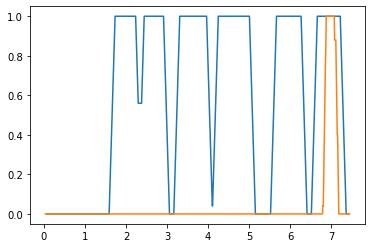

In [27]:
w = 50
(son_idx*1).rolling(int(w),center=True).mean().plot()
(id_idx*1).rolling(int(w/2),center=True).mean().plot()